In [1]:
from tensorflow.keras import backend as K

def clear_memory():
    K.clear_session()
    tf.compat.v1.reset_default_graph()

2025-01-14 07:10:36.264599: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 07:10:36.334454: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import gc
import tensorflow as tf
tf.keras.backend.clear_session()
gc.collect()

23

In [3]:
import numpy as np
import glob
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, Lambda
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import re

# Function to load images and control actions
def load_catalogs(folder: str):
    _img_name, _angle, _throttle, _image = [], [], [], []

    for _file in sorted(glob.glob(f"{folder}/*.catalog"), key=lambda x: [int(c) if c.isdigit() else c for c in re.split(r'(\d+)', x)]):
        with open(_file) as f:
            for _line in f:
                _name = _line.split()[7][1:-2]
                _img_path = os.path.join(f"{folder}/images", _name)
                
                if not os.path.isfile(_img_path):
                    continue
                
                _img = cv2.imread(_img_path)
                if _img is None:
                    continue
                
                assert _img.shape == (224, 224, 3), f"img {_name} has shape {_img.shape}"
                
                _image.append(_img)
                _img_name.append(_name)
                _angle.append(float(_line.split()[9][0:-1]))
                _throttle.append(float(_line.split()[13][0:-1]))

    print(f'Image count: {len(_img_name)}')
    return np.array(_image), np.array(_angle), np.array(_throttle)

# Data preprocessing
def data_preprocessing(images):
    images = images.astype("float32") / 255.0  # Normalize images
    return images

LATENT_DIM = 64  # Size of latent space

# Sampling function for reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
def build_encoder(input_shape=(224, 224, 3), latent_dim=LATENT_DIM):
    inputs = Input(shape=input_shape, name="encoder_input")
    x = Conv2D(32, (3, 3), activation="relu", strides=2, padding="same")(inputs)
    x = Conv2D(64, (3, 3), activation="relu", strides=2, padding="same")(x)
    x = Flatten()(x)
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)
    z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
def build_decoder(latent_dim=LATENT_DIM):
    latent_inputs = Input(shape=(latent_dim,), name="decoder_input")
    x = Dense(56 * 56 * 64, activation="relu")(latent_inputs)
    x = Reshape((56, 56, 64))(x)
    x = Conv2DTranspose(64, (3, 3), activation="relu", strides=2, padding="same")(x)
    x = Conv2DTranspose(32, (3, 3), activation="relu", strides=2, padding="same")(x)
    outputs = Conv2DTranspose(3, (3, 3), activation="sigmoid", padding="same")(x)
    return Model(latent_inputs, outputs, name="decoder")

# Define VAE Model
def build_vae(input_shape=(224, 224, 3), latent_dim=LATENT_DIM):
    encoder = build_encoder(input_shape, latent_dim)
    decoder = build_decoder(latent_dim)
    
    inputs = Input(shape=input_shape, name="vae_input")
    z_mean, z_log_var, z = encoder(inputs)
    outputs = decoder(z)
    
    vae = Model(inputs, outputs, name="vae")

    # VAE Loss
    reconstruction_loss = tf.keras.losses.MeanSquaredError()(inputs, outputs)
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    vae_loss = reconstruction_loss + 0.01 * kl_loss
    vae.add_loss(vae_loss)
    vae.compile(optimizer="adam")
    
    return vae, encoder



In [11]:
import matplotlib.pyplot as plt
import time

def plot_trained_model(history, show: bool = False, save: bool = True):
    """Plots training loss and metrics from model history."""
    
    # Extract history data
    history_dict = history.history

    # Plot Loss
    plt.figure(figsize=(8, 4))
    plt.plot(history_dict['loss'], label='Train Loss')
    plt.plot(history_dict['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    if save:
        plt.savefig(f'Loss_{int(time.time())}.png', bbox_inches='tight')
    if show:
        plt.show()

    # Check if accuracy or other metrics exist before plotting
    if 'accuracy' in history_dict:
        plt.figure(figsize=(8, 4))
        plt.plot(history_dict['accuracy'], label='Train Accuracy')
        plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        if save:
            plt.savefig(f'Accuracy_{int(time.time())}.png', bbox_inches='tight')
        if show:
            plt.show()
    elif 'mae' in history_dict:  # Plot MAE instead for regression models
        plt.figure(figsize=(8, 4))
        plt.plot(history_dict['mae'], label='Train MAE')
        plt.plot(history_dict['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.ylabel('Mean Absolute Error')
        plt.xlabel('Epoch')
        plt.legend()
        if save:
            plt.savefig(f'MAE_{int(time.time())}.png', bbox_inches='tight')
        if show:
            plt.show()


In [5]:
# Load and preprocess data
data_folder = "/home/UFAD/mohitkukreja/Documents/data_perfect_driving"
images, angles, throttles = load_catalogs(data_folder)
images = data_preprocessing(images)

y = np.array(angles)

# Split data
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2, random_state=42)

# Build and train VAE
vae, encoder = build_vae()
vae.fit(X_train, X_train, epochs=30, batch_size=16, validation_data=(X_test, X_test))

# Clear GPU memory before making predictions
tf.keras.backend.clear_session()
gc.collect()

# Ensure TensorFlow recognizes the GPU
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# Extract latent representations safely
with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
    latent_output_train = encoder.predict(X_train, batch_size=16)  
    latent_output_test = encoder.predict(X_test, batch_size=16)

# Ensure correct indexing (check if encoder.predict returns multiple outputs)
if isinstance(latent_output_train, (list, tuple)) and len(latent_output_train) > 2:
    X_train_latent = latent_output_train[2]
    X_test_latent = latent_output_test[2]
else:
    raise ValueError(f"Expected encoder.predict() to return at least 3 elements, but got {len(latent_output_train)}")

print("Latent representations extracted successfully!")



Image count: 12445


2025-01-14 07:12:26.812020: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21263 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:31:00.0, compute capability: 8.6
2025-01-14 07:12:26.819602: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22350 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b1:00.0, compute capability: 8.6


Epoch 1/30


2025-01-14 07:12:38.425150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-01-14 07:12:38.589764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-01-14 07:12:39.104170: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb17d1ef710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-14 07:12:39.104217: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-14 07:12:39.104225: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-14 07:12:39.109899: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-14 

623/623 [==============================] - 27s 36ms/step - loss: 0.0162 - val_loss: 0.0071
Epoch 2/30
623/623 [==============================] - 19s 30ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 3/30
623/623 [==============================] - 19s 30ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 4/30
623/623 [==============================] - 19s 31ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 5/30
623/623 [==============================] - 20s 32ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 6/30
623/623 [==============================] - 19s 31ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 7/30
623/623 [==============================] - 19s 30ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 8/30
623/623 [==============================] - 19s 30ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 9/30
623/623 [==============================] - 20s 31ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 10/30
623/623 [==============================] - 19s 31ms/step - loss: 0.0050 - val_los

Control model defined and compiled.
Epoch 1/20
623/623 [==============================] - 9s 11ms/step - loss: 0.2094 - mae: 0.3538 - val_loss: 0.1847 - val_mae: 0.3335
Epoch 2/20
623/623 [==============================] - 7s 11ms/step - loss: 0.1503 - mae: 0.2934 - val_loss: 0.1703 - val_mae: 0.3092
Epoch 3/20
623/623 [==============================] - 6s 10ms/step - loss: 0.1354 - mae: 0.2744 - val_loss: 0.1653 - val_mae: 0.3048
Epoch 4/20
623/623 [==============================] - 8s 12ms/step - loss: 0.1259 - mae: 0.2641 - val_loss: 0.1727 - val_mae: 0.3132
Epoch 5/20
623/623 [==============================] - 7s 11ms/step - loss: 0.1181 - mae: 0.2560 - val_loss: 0.1703 - val_mae: 0.3171
Epoch 6/20
623/623 [==============================] - 7s 12ms/step - loss: 0.1125 - mae: 0.2504 - val_loss: 0.1717 - val_mae: 0.3116
Epoch 7/20
623/623 [==============================] - 8s 12ms/step - loss: 0.1058 - mae: 0.2414 - val_loss: 0.1722 - val_mae: 0.3118
Epoch 8/20
623/623 [=============

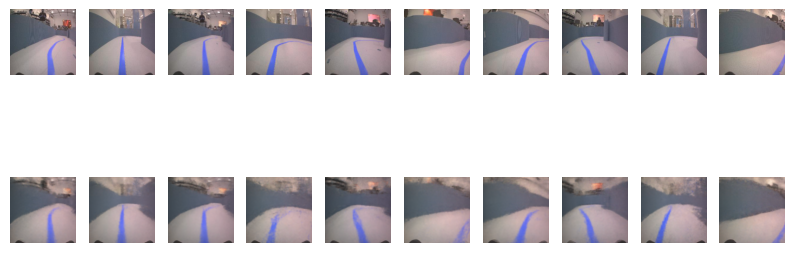

In [7]:
from tensorflow.keras import Sequential

# Define control model
control_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_latent.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Output a single control value
])

control_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print("Control model defined and compiled.")

# Train the model
control_model.fit(X_train_latent, y_train, epochs=20, batch_size=16, validation_data=(X_test_latent, y_test))

# Evaluate the model
loss, mae = control_model.evaluate(X_test_latent, y_test)
print(f"Control Model Loss: {loss}, MAE: {mae}")

# Visualize reconstructed images
reconstructed_images = vae.predict(X_test[:10])
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    
    plt.subplot(2, 10, i+11)
    plt.imshow(reconstructed_images[i])
    plt.axis('off')
    
plt.show()



1/1 [==============================] - 0s 88ms/step


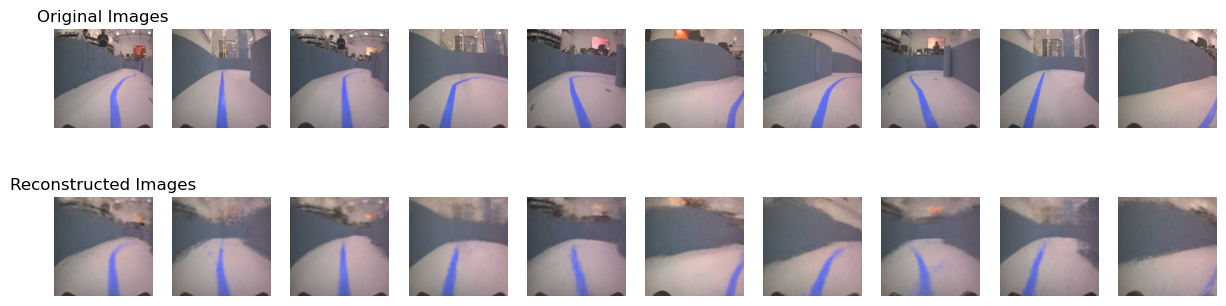

In [8]:
import matplotlib.pyplot as plt

# Select a few test images
num_samples = 10
reconstructed_images = vae.predict(X_test[:num_samples])

# Plot original and reconstructed images
fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))

for i in range(num_samples):
    # Original image
    axes[0, i].imshow(X_test[i])
    axes[0, i].axis("off")
    # Reconstructed image
    axes[1, i].imshow(reconstructed_images[i])
    axes[1, i].axis("off")

axes[0, 0].set_title("Original Images")
axes[1, 0].set_title("Reconstructed Images")
plt.show()


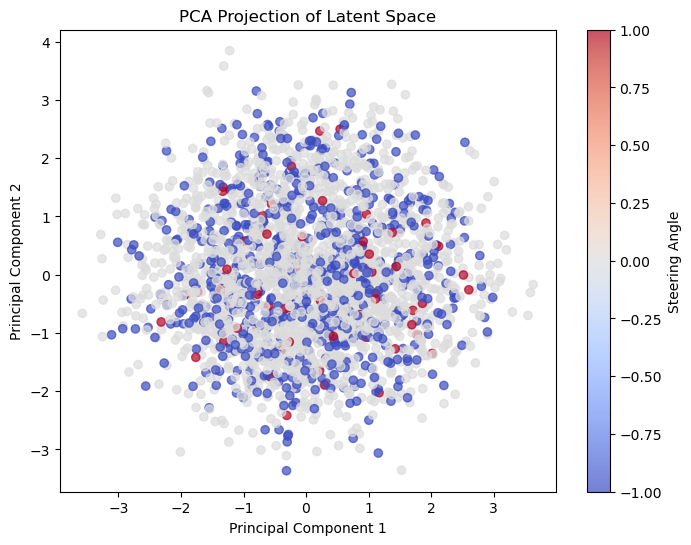

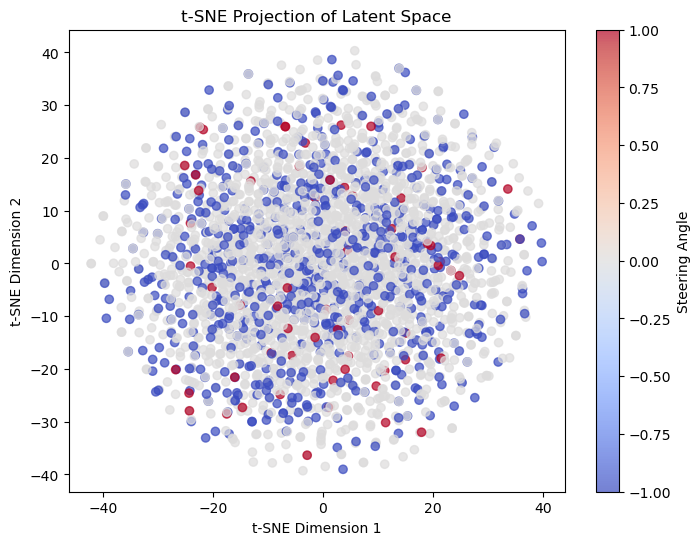

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Reduce dimensions using PCA
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(X_test_latent)

# Plot PCA
plt.figure(figsize=(8, 6))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=angles[len(X_train_latent):], cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Steering Angle")
plt.title("PCA Projection of Latent Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
latent_tsne = tsne.fit_transform(X_test_latent)

# Plot t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=angles[len(X_train_latent):], cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Steering Angle")
plt.title("t-SNE Projection of Latent Space")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


Epoch 1/20
623/623 [==============================] - 6s 10ms/step - loss: 0.0589 - mae: 0.1835 - val_loss: 0.2148 - val_mae: 0.3454
Epoch 2/20
623/623 [==============================] - 7s 11ms/step - loss: 0.0575 - mae: 0.1810 - val_loss: 0.2214 - val_mae: 0.3528
Epoch 3/20
623/623 [==============================] - 7s 11ms/step - loss: 0.0567 - mae: 0.1798 - val_loss: 0.2205 - val_mae: 0.3504
Epoch 4/20
623/623 [==============================] - 7s 11ms/step - loss: 0.0547 - mae: 0.1777 - val_loss: 0.2248 - val_mae: 0.3517
Epoch 5/20
623/623 [==============================] - 7s 11ms/step - loss: 0.0534 - mae: 0.1746 - val_loss: 0.2253 - val_mae: 0.3574
Epoch 6/20
623/623 [==============================] - 7s 11ms/step - loss: 0.0520 - mae: 0.1726 - val_loss: 0.2255 - val_mae: 0.3543
Epoch 7/20
623/623 [==============================] - 5s 9ms/step - loss: 0.0515 - mae: 0.1718 - val_loss: 0.2285 - val_mae: 0.3556
Epoch 8/20
623/623 [==============================] - 6s 10ms/step - l

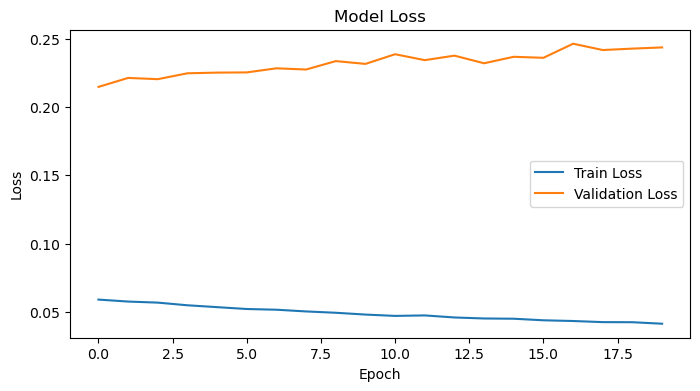

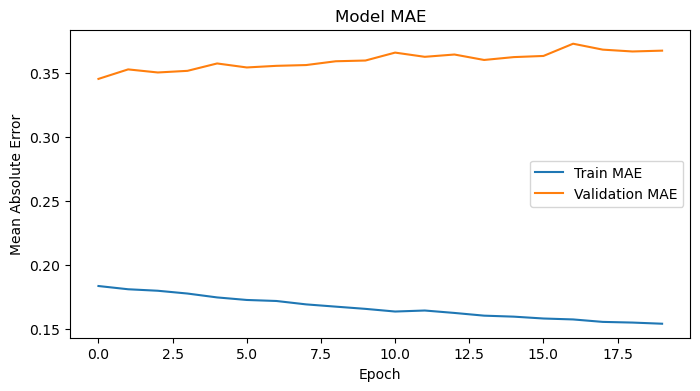

In [12]:
history = control_model.fit(X_train_latent, y_train, epochs=20, batch_size=16, validation_data=(X_test_latent, y_test))
plot_trained_model(history, show=True, save=True)


78/78 [==============================] - 0s 2ms/step
MSE: 0.2438, R2 Score: 0.0783


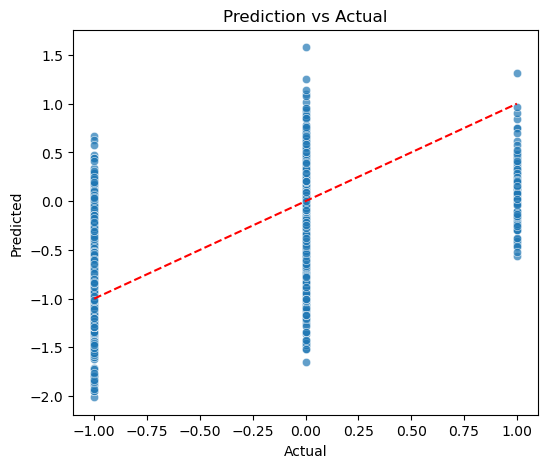

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Predict control values
y_pred = control_model.predict(X_test_latent)

# Ensure y_test and y_pred are 2D (N, 2) if necessary
y_test = y_test.reshape(-1, 1) if y_test.ndim == 1 else y_test
y_pred = y_pred.reshape(-1, 1) if y_pred.ndim == 1 else y_pred

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}, R2 Score: {r2:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test.flatten(), y=y_pred.flatten(), alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title("Prediction vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()
